## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [2]:
df = pd.read_csv(r"Data/final_data.csv")

In [3]:
df.shape

(10754, 22)

In [4]:
df.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [5]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [6]:
# Completeness
df.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [7]:
# Accurecy types
df.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [8]:
#made a new goalkeeper df
#df_goalkeeper = df[df['position'] == 'Goalkeeper']
df.drop('player', axis=1, inplace=True)
df.drop('goals conceded', axis=1, inplace=True)
df.drop('clean sheets', axis=1, inplace=True)
df.drop('name', axis=1, inplace=True)

# Drop rows where position is 'Goalkeeper'
#df = df[df['position'] != 'Goalkeeper']


In [9]:
# Select numerical columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Select categorical columns
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features

['team', 'position']

In [10]:
# Calculate the frequency of each 'team'
type_counts = df['team'].value_counts()

# Filter 'team' values that appear 10 or more times
df = df[df['team'].isin(type_counts[type_counts >= 20].index)]

In [11]:
df.shape

(10736, 18)

In [12]:
# Calculate the frequency of each position
position_counts = df['position'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['position'].isin(position_counts[position_counts >=30].index)]

In [13]:
df.shape

(10736, 18)

In [14]:
# Filter rows based on 'current_value' to include only values between 2,000 and 3,000,000
df = df[(df['current_value'] > 2000) & (df['current_value'] <= 3000000)]

# Filter rows where 'minutes played' is between 50 and 9,000
df = df[(df['minutes played'] >= 50) & (df['minutes played'] <= 9000)]

# Filter rows with player 'height' between 164 cm and 200 cm
df = df[(df['height'] >= 164) & (df['height'] <= 200)]

# Filter rows based on 'highest_value' to include values between 2,000 and 30,000,000
df = df[(df['highest_value'] > 2000) & (df['highest_value'] <= 30000000)]

# Filter rows for players aged between 18 and 35
df = df[(df['age'] >= 18) & (df['age'] <= 35)]

# Filter rows where 'appearance' count is between 1 and 79
df = df[(df['appearance'] > 0) & (df['appearance'] < 80)]

# Filter rows where 'award' count is 10 or fewer
df = df[df['award'] <= 10]


In [15]:
df.shape

(7036, 18)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [16]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
1,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1304,510,58,1,1500000,22000000,1,0
7,Manchester United,Defender Centre-Back,185.0,31.0,8,0.0,0.0,0.216346,0.0,0.0,416,932,169,7,2000000,20000000,2,0


In [17]:
categorical_features

['team', 'position']

In [18]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [19]:
df.shape

(7036, 400)

In [20]:
df.head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,minutes played,days_injured,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
1,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1304,510,...,False,False,False,True,False,False,False,False,False,False
7,185.0,31.0,8,0.0,0.0,0.216346,0.0,0.0,416,932,...,True,False,False,False,False,False,False,False,False,False


In [21]:
# Calculate the 25th and 85th percentiles of 'current_value'
p25 = df['current_value'].quantile(0.25)
p85 = df['current_value'].quantile(0.85)

# Function to categorize 'current_value' based on percentiles
def categorize_current_value(current_value):
    if current_value < p25:
        return 'Cheap'
    elif current_value < p85:
        return 'Moderate'
    else:
        return 'Expensive'

# Apply the function to create a new column 'current_value_category'
df['current_value_category'] = df['current_value'].apply(categorize_current_value)

# Optionally, drop the original 'current_value' column
df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['current_value_category'].value_counts())


current_value_category
Moderate     4112
Cheap        1744
Expensive    1180
Name: count, dtype: int64


In [22]:
p25, p85

(275000.0, 1800000.0)

In [23]:
encoder = LabelEncoder()
df['current_value_category_encoded'] = encoder.fit_transform(df['current_value_category'])  

#### 3. Feature selection

In [24]:
correlation = df.corr(numeric_only=True)
print(correlation['current_value_category_encoded'].sort_values(ascending=False))

current_value_category_encoded    1.000000
appearance                        0.217743
minutes played                    0.208910
age                               0.199418
award                             0.161911
                                    ...   
team_Chippa United               -0.071667
team_Marumo Gallants FC          -0.078094
position_Attack                  -0.084156
position_midfield                -0.094733
position_Goalkeeper              -0.108650
Name: current_value_category_encoded, Length: 400, dtype: float64


In [25]:
# Set the correlation threshold
threshold = 0.09 # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value_category_encoded']) > \
threshold]['current_value_category_encoded'].index
selected_features

Index(['age', 'appearance', 'minutes played', 'days_injured', 'games_injured',
       'award', 'highest_value', 'position_Goalkeeper', 'position_midfield',
       'current_value_category_encoded'],
      dtype='object')

In [26]:
selected_features = ['age', 'appearance', 'minutes played', 'days_injured', 'games_injured',
       'award', 'highest_value', 'position_Goalkeeper', 'position_midfield',
       'current_value_category_encoded']

In [27]:
df = df[selected_features]
df.head()

,age,appearance,minutes played,days_injured,games_injured,award,highest_value,position_Goalkeeper,position_midfield,current_value_category_encoded
1,30.0,15,1304,510,58,1,22000000,True,False,2
7,31.0,8,416,932,169,7,20000000,False,False,1
8,21.0,34,2758,47,13,0,2000000,False,False,1
20,20.0,39,2788,0,0,1,800000,False,False,2
21,18.0,51,3512,0,0,1,800000,False,False,2


#### 4. Prepare train and test data

In [28]:
# Prepare data
X = df.drop(['current_value_category_encoded'], axis=1)
y = df['current_value_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
X.shape

(7036, 9)

## Buliding the Model

In [30]:
svm_classifier = SVC() 

In [31]:
param_grid = {
    'kernel': [
             # 'linear',
               'rbf',
             # 'poly'
              ],   # Regularization strength
    'C':[0, 2, 5, 10, 15, 20, 25],
    'gamma': [1,2,6]
}
grid_search = GridSearchCV(estimator=svm_classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [32]:
# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0, 2, 5, 10, 15, 20, 25], 'gamma': [1, 2, 6],
                         'kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

In [33]:
grid_search.best_params_

{'C': 2, 'gamma': 1, 'kernel': 'rbf'}

In [34]:
model = grid_search.best_estimator_

## Test the Model

In [35]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Evaluating the Model 

In [36]:
# our benchmark model
base_model = round(df['current_value_category_encoded'].value_counts()[1]/df.shape[0]*100, 2)
base_model

16.77

1. Accuracy

In [37]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7805397727272727

In [38]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.9074271499644634

In [39]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[243,   0,  91],
       [  0, 124, 114],
       [ 49,  55, 732]], dtype=int64)

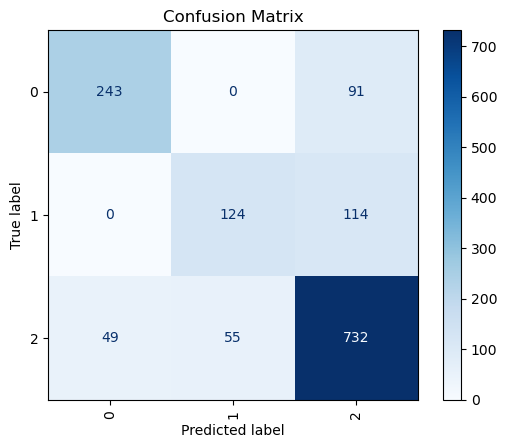

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [41]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.77


In [42]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.71


In [43]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.73


In [44]:
print(classification_report(y_test,
                      y_pred,
                      labels=list(model.classes_)))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       334
           1       0.69      0.52      0.59       238
           2       0.78      0.88      0.83       836

    accuracy                           0.78      1408
   macro avg       0.77      0.71      0.73      1408
weighted avg       0.78      0.78      0.77      1408



In [ ]:
# Select two features from your dataset
X_two_features = X.iloc[:, [0, 1]]  # Replace with the indices of the two features you want to use

# Retrain your SVM model using these two features
model.fit(X_two_features, y)

# Now plot the decision boundary as before
h = .02  # Step size in the mesh
x_min, x_max = X_two_features.iloc[:, 0].min() - 1, X_two_features.iloc[:, 0].max() + 1
y_min, y_max = X_two_features.iloc[:, 1].min() - 1, X_two_features.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

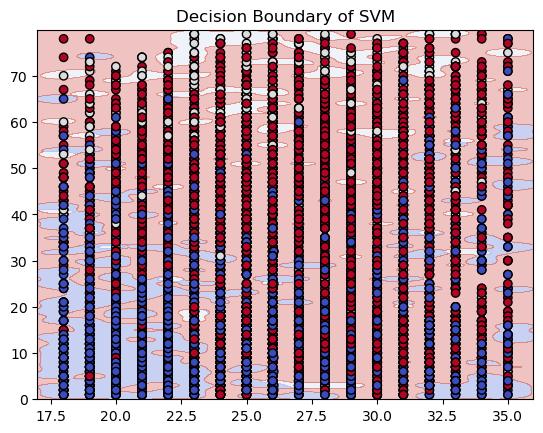

In [47]:
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_two_features.iloc[:, 0], X_two_features.iloc[:, 1], c=y, edgecolor='k', marker='o', cmap=plt.cm.coolwarm)
plt.title('Decision Boundary of SVM')
plt.show()